In [1]:
import pandas as pd
import numpy as np

In [101]:
clutch = pd.read_csv("../data/ClutchPlayerData.csv")
boxscores = pd.read_csv("../data/BoxscoreData.csv")

In [102]:
sched = pd.read_csv("../data/ScheduleData.csv")
playoff_sched = pd.read_csv("../data/PlayoffScheduleData.csv")

#Now we're going to use players clutch stats to predict whether they will be playoff risers or fallers.

In [103]:
stints = pd.read_csv("../data/pbp_stints_plusminus.csv")

In [104]:
sched["year"] = sched["url"].str.split("/").str[-1].str[:4]
sched["month"] = sched["url"].str.split("/").str[-1].str[4:6]
sched["day"] = sched["url"].str.split("/").str[-1].str[6:8]
sched = sched.loc[sched.game_id.isin(stints.game_id.unique())] #We only need the ones that actually show up in stints

In [105]:
sched['date'] = pd.to_datetime(sched[['year', 'month', 'day']])


#These were found online, start and end dates for recent NBA seasons
season_bounds = [
    ("2022", pd.Timestamp("2021-10-19"), pd.Timestamp("2022-04-10")),
    ("2023", pd.Timestamp("2022-10-18"), pd.Timestamp("2023-04-09")),
    ("2024", pd.Timestamp("2023-10-24"), pd.Timestamp("2024-04-14")),
    ("2025", pd.Timestamp("2024-10-22"), pd.Timestamp("2025-04-13")),
]

def assign_season(dt):
    for season_name, start, end in season_bounds:
        if (dt >= start) & (dt <= end):
            return season_name
    return None


sched['season'] = sched['date'].apply(assign_season)

In [106]:
sched = sched.loc[~sched["season"].isnull()] #Now we have 2022 season on

In [107]:
#First we'll filter down the clutch players to be the best on their team, so we need to add the team info

def find_team(player_id, game_id):
    home = boxscores.loc[(boxscores['Game_ID'] == game_id) & (boxscores['Player_ID'] == player_id), 'Home']
    if len(home) == 0:
        return None
    home = home.values[0]
    if home:
        team = sched.loc[sched['game_id'] == game_id, 'Home Team'].values
    else:
        team = sched.loc[sched['game_id'] == game_id, 'Away Team'].values
    if len(team) == 0:
        return None
    return team


In [108]:
clutch['team'] = clutch.apply(lambda row: find_team(row['player_id'], row['game_id']), axis=1)

In [109]:
clutch = clutch.loc[~clutch['team'].isnull()]
clutch = clutch.merge(sched[['game_id', 'season']], left_on='game_id', right_on='game_id', how='left', suffixes=('', '_sched'))

In [110]:
clutch['team'] = clutch['team'].apply(lambda x: x[0] if len(x) > 0 else None)


In [111]:
player_counts = (clutch.groupby(['season', 'team', 'player_id']).size().reset_index(name='games'))
top7 = (player_counts.sort_values(['season', 'team', 'games'], ascending=[True, True, False]).groupby(['season', 'team']).head(7))

In [112]:
clutch_for_mean = clutch.merge(top7[['season', 'team', 'player_id']], on=['season', 'team', 'player_id'], how='inner')

In [113]:
modeling_time = clutch_for_mean.groupby(["season", "team", "player_id"]).mean()

In [121]:
playoff_box = pd.read_csv("../data/PlayoffBoxScoreData.csv")
playoff_sched = pd.read_csv("../data/PlayoffScheduleData.csv")
playoff_box = playoff_box.merge(playoff_sched[['game_id', 'Year']], left_on='Game_ID', right_on='game_id', how='left', suffixes=('', '_sched'))

In [146]:
playoff_stats = playoff_box.groupby(["Player_ID", "Year"]).mean(numeric_only=True)

In [147]:
playoff_stats["PRA"] = playoff_stats["PTS"] + playoff_stats["TRB"] + playoff_stats["AST"] #This is the stat we will be predicting

In [ ]:
playoff_stats = playoff_stats.reset_index()[["Year", "Player_ID", "PRA"]].rename(columns={"Year": "season", "Player_ID": "player_id"})
modeling_time = modeling_time.reset_index()
modeling_time["season"] = modeling_time["season"].astype(int)
modeling_time = modeling_time.merge(playoff_stats, on=["season", "player_id"], how="left")

,season,team,player_id,game_id,points,rebounds,assists,2pm,2pa,3pm,...,FGM,FGA,offensive rebounds,defensive rebounds,fouls,fouls drawn,turnovers,steals,blocks,PRA
0,2022,Atlanta Hawks,bogdabo01,12408.562500,1.687500,0.312500,0.062500,0.250000,0.312500,0.375000,...,0.625000,1.562500,0.187500,0.125000,0.312500,0.062500,0.062500,0.062500,0.000000,22.000000
1,2022,Atlanta Hawks,capelca01,12347.478261,0.521739,0.391304,0.000000,0.217391,0.217391,0.000000,...,0.217391,0.217391,0.086957,0.304348,0.304348,0.043478,0.000000,0.000000,0.173913,9.500000
2,2022,Atlanta Hawks,collijo01,12086.285714,0.928571,1.214286,0.071429,0.357143,0.571429,0.000000,...,0.357143,0.714286,0.142857,1.071429,0.285714,0.285714,0.071429,0.000000,0.071429,15.200000
3,2022,Atlanta Hawks,gallida01,12304.400000,0.300000,0.100000,0.150000,0.050000,0.150000,0.000000,...,0.050000,0.450000,0.050000,0.050000,0.300000,0.150000,0.000000,0.050000,0.000000,15.200000
4,2022,Atlanta Hawks,huertke01,12324.294118,0.882353,0.647059,0.235294,0.176471,0.294118,0.117647,...,0.294118,0.647059,0.117647,0.529412,0.588235,0.176471,0.176471,0.000000,0.117647,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2024,Washington Wizards,gaffoda01,14513.363636,1.545455,1.181818,0.272727,0.727273,0.818182,0.000000,...,0.727273,0.818182,0.363636,0.818182,0.454545,0.181818,0.000000,0.000000,0.090909,15.181818
626,2024,Washington Wizards,jonesty01,14664.850000,0.800000,0.100000,0.950000,0.250000,0.550000,0.050000,...,0.300000,0.750000,0.000000,0.100000,0.250000,0.100000,0.050000,0.100000,0.050000,NaN
627,2024,Washington Wizards,kispeco01,14927.529412,1.117647,0.176471,0.176471,0.235294,0.470588,0.117647,...,0.352941,0.764706,0.117647,0.058824,0.235294,0.176471,0.058824,0.000000,0.000000,NaN
628,2024,Washington Wizards,kuzmaky01,14713.440000,1.840000,0.440000,0.280000,0.440000,1.080000,0.200000,...,0.640000,1.840000,0.240000,0.200000,0.520000,0.200000,0.280000,0.040000,0.120000,NaN


In [151]:
modeling_time = modeling_time.loc[~modeling_time["PRA"].isnull()]

In [ ]:
#Alright, now we have to pick columns from modeling time to predict on
to_model = modeling_time[["points", "rebounds", "2pa", "FTM", "FGA depth", "assists", "steals", "blocks", "turnovers", "PRA"]]

In [162]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error

X = to_model.drop(columns=['PRA'])
y = to_model['PRA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_estimators=500)
model.fit(X_train, y_train)

preds = model.predict(X_test)

print("R²:", r2_score(y_test, preds))
print("RMSE:", root_mean_squared_error(y_test, preds))

R²: 0.7329740211024085
RMSE: 5.838655402624545


In [191]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#and clustering...

new_X = to_model[["points", "rebounds", "assists", "2pa"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(new_X)

kmeans = KMeans(n_clusters=4)

to_model["cluster"] = kmeans.fit_predict(X_scaled)


/var/folders/_b/t1t41vkj1vngyhrv0pg1fbg80000gn/T/ipykernel_90364/1510621871.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_model["cluster"] = kmeans.fit_predict(X_scaled)


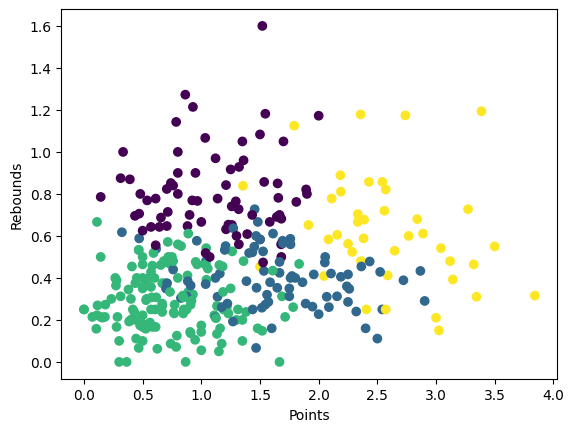

In [192]:
import matplotlib.pyplot as plt
plt.scatter(to_model['points'], to_model['rebounds'], c=to_model['cluster'])
plt.xlabel("Points")
plt.ylabel("Rebounds")
plt.show()

In [193]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, to_model["cluster"])
score

0.3222626943013147

In [201]:
player_counts = stints['player_id'].value_counts()
valid_ids = player_counts[player_counts > 500].index
filt_stints = stints[stints['player_id'].isin(valid_ids)]

In [204]:
filt_stints_grouped = filt_stints.groupby("player_id")["new +/-"].mean()
filt_stints_grouped.sort_values(ascending=False)[:20]

player_id
mclaujo01    0.543772
gordoaa01    0.542910
toppiob01    0.511482
alvarjo01    0.503289
paytoga02    0.498834
inglejo01    0.482536
hausesa01    0.472928
gibsota01    0.472076
landajo01    0.447058
livelde01    0.441657
murphtr02    0.438500
mykhasv01    0.431672
murraja01    0.430182
bertada01    0.421112
jokicni01    0.418987
kesslwa01    0.408868
carusal01    0.406827
lopezbr01    0.388005
paulch01     0.384839
sharpda01    0.383798
Name: new +/-, dtype: float64

In [209]:
filt_stints_grouped[filt_stints_grouped.index == "maxeyty01"]

player_id
maxeyty01    0.294508
Name: new +/-, dtype: float64